In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import glob
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = os.path.abspath('')+'/../data/'
AUGMENTED_IMAGE_DIR = os.path.abspath('') + '/augmented_samples/'
os.makedirs(AUGMENTED_IMAGE_DIR, exist_ok=True)
IMG_SIZE = 64 # All images will be resized 64x64
BATCH_SIZE=16

def format_example(image):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
#     image = tf.repeat(image, 3, -1)
    return image

raw_ds = keras.preprocessing.image.ImageDataGenerator(
    validation_split=.2,
#     featurewise_center=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
#     preprocessing_function=keras.applications.resnet50.preprocess_input
)

train_ds = raw_ds.flow_from_directory(directory=DATA_FOLDER, 
                                target_size=(IMG_SIZE, IMG_SIZE),
                                color_mode='rgb',
                                classes=('negatives', 'positives'),
                                batch_size=BATCH_SIZE,
#                                 save_to_dir=AUGMENTED_IMAGE_DIR,
                                subset='training'
                            )

valid_ds = raw_ds.flow_from_directory(directory=DATA_FOLDER, 
                                target_size=(IMG_SIZE, IMG_SIZE),
                                color_mode='rgb',
                                classes=('negatives', 'positives'),
                                batch_size=BATCH_SIZE,
#                                 save_to_dir=AUGMENTED_IMAGE_DIR,
                                subset='validation'
                            )

Found 114 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


/home/tornike/.anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


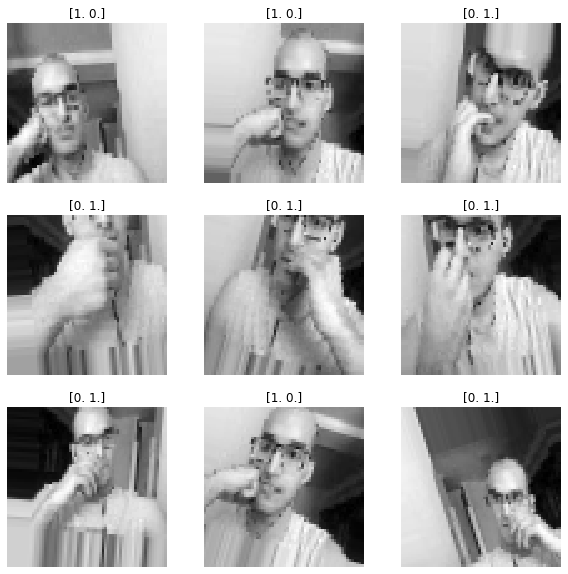

In [3]:
def sample(dataset, n=1):
    iterator = iter(dataset)
    return [next(dataset) for _ in range(n)]

plt.figure(figsize=(10, 10))
for images, labels in sample(train_ds,1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        max_ = tf.reduce_max(images[i])
        min_ = tf.reduce_min(images[i])
        img = (images[i] - min_) / (max_ - min_)
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis("off")

## Define model

In [4]:
IMG_SHAPE =  (IMG_SIZE, IMG_SIZE, 3)
base_model = keras.applications.resnet50.ResNet50(include_top=False,
                                                 input_shape=IMG_SHAPE,
                                                 )
base_model.trainable = False
global_average_layer = keras.layers.GlobalAveragePooling2D()
prediction_layer= tf.keras.layers.Dense(2, activation='softmax')

In [5]:
model = keras.models.Sequential([
#     keras.layers.Lambda(keras.applications.resnet50.preprocess_input),
    base_model,
    global_average_layer,
    prediction_layer,
])

In [6]:
base_lr = 1e-3
model.compile(optimizer=keras.optimizers.RMSprop(lr=base_lr),
             loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )

In [7]:
initial_epochs = 30

loss0,accuracy0 = model.evaluate(train_ds,
                                steps=len(train_ds))

8/8 [==============================] - 1s 71ms/step - loss: 1.5624 - accuracy: 0.5351


In [8]:
callbacks = [keras.callbacks.EarlyStopping(patience=15,
                                           restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau()]
history = model.fit(train_ds,
                    steps_per_epoch=len(train_ds),
                    epochs=initial_epochs,
                    validation_data=valid_ds,
                    validation_steps=len(valid_ds),
                   callbacks=callbacks)

Epoch 1/30
8/8 [==============================] - 1s 101ms/step - loss: 1.4068 - accuracy: 0.5789 - val_loss: 0.5388 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - 1s 98ms/step - loss: 0.4737 - accuracy: 0.8246 - val_loss: 0.4214 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 3/30
8/8 [==============================] - 1s 94ms/step - loss: 0.3502 - accuracy: 0.8860 - val_loss: 0.2466 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 4/30
8/8 [==============================] - 1s 91ms/step - loss: 0.5327 - accuracy: 0.7982 - val_loss: 0.4703 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 5/30
8/8 [==============================] - 1s 91ms/step - loss: 0.2587 - accuracy: 0.8947 - val_loss: 0.3235 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 6/30
8/8 [==============================] - 1s 89ms/step - loss: 0.2494 - accuracy: 0.9035 - val_loss: 0.5133 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 7/30
8/8 [==============================] - 1s 90ms/step - loss: 0.4150 - accurac

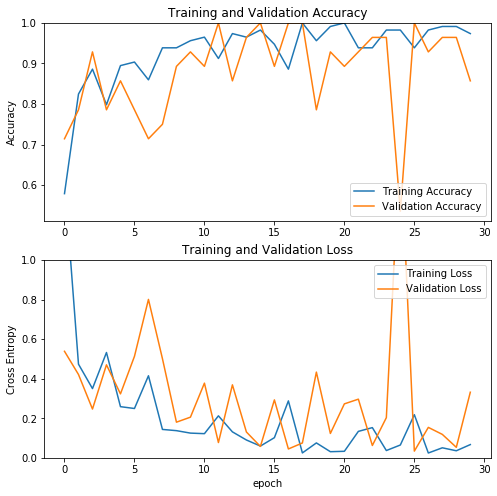

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [10]:
loss0,accuracy0 = model.evaluate(train_ds,
                                steps=len(valid_ds))

2/2 [==============================] - 0s 44ms/step - loss: 0.0053 - accuracy: 1.0000


In [11]:
model.save('../export/0001')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../export/0001/assets
